In [28]:
# data preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

egypt_houses = pd.read_csv('egypt_real_estate_listings.csv')

cities = [
    "Abu El Matamir", "Abu Hummus", "Abu Tesht", "Abu Tig", "Akhmim", "Al Khankah", 
    "Alexandria", "Arish", "Ashmoun", "Aswan", "Awsim", "Badr", "Baltim", "Banha", 
    "Beni Suef", "Borg El Arab", "Cairo", "Damanhur", "Damietta", "Desouk", "Dumyat", 
    "El Alamein", "El Mahalla El Kubra", "El Zarqa", "Faiyum", "Fustat", "Giza", 
    "Hurghada", "Ismailia", "Jaheyna City", "Kafr Saad", "Luxor", "Mansoura", 
    "Minya", "New Cairo", "Port Said", "Qena", "Rosetta", "Sharm El Sheikh", 
    "Shubra El Kheima", "Suez", "Tanta", "Zagazig"
]

location_input = input('\nCity: ')
size_input = float(input('\nSize: '))
bedrooms_input = float(input('\nBedrooms: '))

def extract_city(location):
    if isinstance(location, str):
        for city in cities:
            if city.lower() in location.lower():
                return city
    return np.nan

# preprocessing
egypt_houses['location'] = egypt_houses['location'].apply(extract_city)
egypt_houses = egypt_houses.dropna(subset=['location', 'price', 'size', 'bedrooms'])
egypt_houses = egypt_houses[egypt_houses['bedrooms'].str.contains(r'\d')]

egypt_houses['price'] = egypt_houses['price'].str.replace(',', '')
egypt_houses['size'] = egypt_houses['size'].str.replace(',', '')
egypt_houses['size'] = egypt_houses['size'].str.extract(r'/\s*([\d,]+)\s*sqm')[0]
egypt_houses['bedrooms'] = egypt_houses['bedrooms'].str.replace(r'\D', '', regex=True)

egypt_houses['price'] = egypt_houses['price'].astype(float)
egypt_houses['size'] = egypt_houses['size'].astype(float)
egypt_houses['bedrooms'] = egypt_houses['bedrooms'].astype(float)

egypt_houses = egypt_houses[
    (egypt_houses['price'] <= 20000000.0) & 
    (egypt_houses['price'] >= 50000.0) &
    (egypt_houses['size'] <= 1000.0) & 
    (egypt_houses['bedrooms'] <= 20.0)
]

avg_prices = egypt_houses.groupby('location', as_index=False)['price'].mean()
analysed_houses = egypt_houses[egypt_houses['location'] == location_input][['location', 'size', 'bedrooms', 'price']].copy()
print('Preprocessing done')




City:  Cairo

Size:  120

Bedrooms:  3


Preprocessing done


In [29]:
# correlation-regression prognose by Ridge 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

city = location_input
city_data = egypt_houses[egypt_houses['location'] == city].copy()

if city_data.empty:
    raise ValueError(f"The '{city}' city is not found")

# signs and purpose
X = city_data[['size', 'bedrooms']]
y = city_data['price']

# polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns), index=X.index)

# division into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# model
model = Ridge(alpha=0.8)
model.fit(X_train, y_train)

# metrics
y_pred = model.predict(X_test)
print(f"Model for the: {city} city")
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# user input
input_df = pd.DataFrame({
    'size': [size_input],
    'bedrooms': [bedrooms_input]
})
input_poly = poly.transform(input_df)
input_poly = pd.DataFrame(input_poly, columns=poly.get_feature_names_out(X.columns))

# prognose
pred_price = model.predict(input_poly)
print(f"Price prognose in {city}: {pred_price[0]:,.0f} EGP")

Model for the: Cairo city
R²: 0.23223503765751596
MSE: 14479546581844.588
Price prognose in Cairo: 5,612,812 EGP


C:\Users\Impacto Gaming 12\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.21599e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


C:\Users\Impacto Gaming 12\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


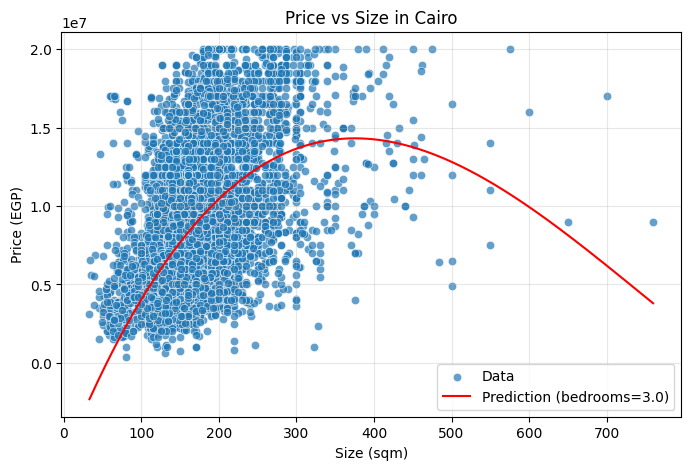

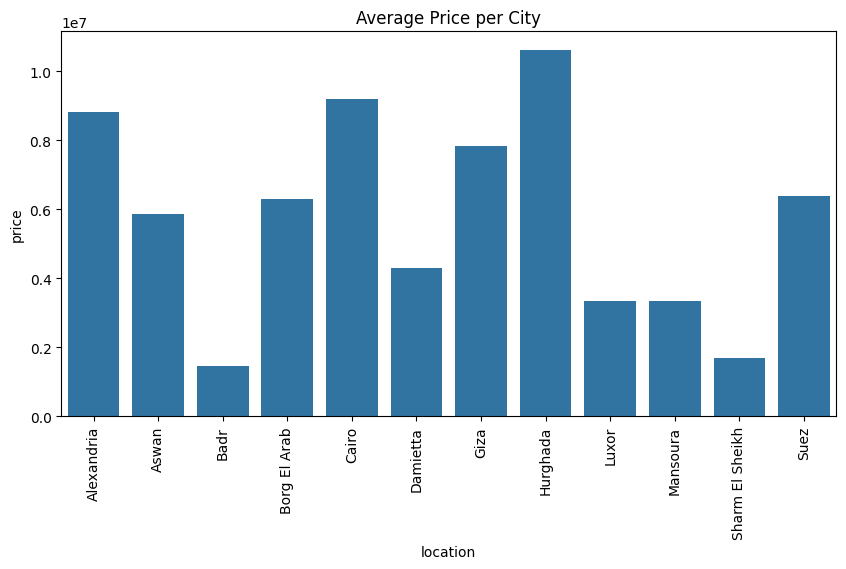

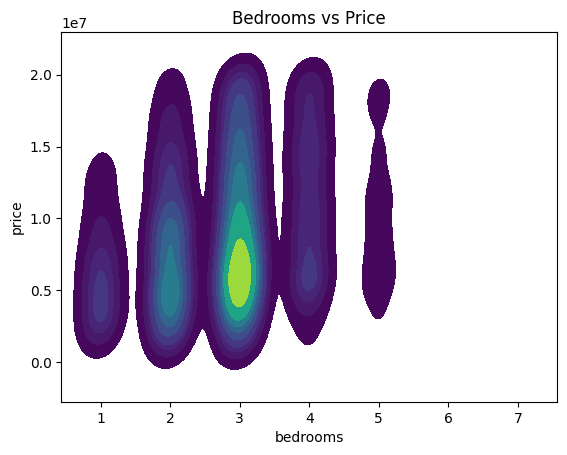

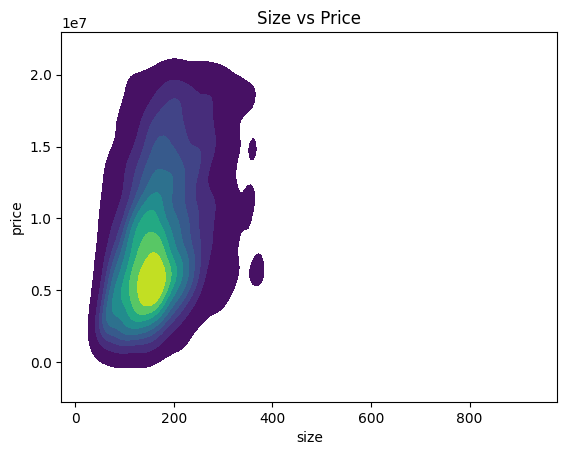

In [30]:
# some visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# prediction range
X_pred = np.linspace(city_data['size'].min(), city_data['size'].max(), 200)
bedrooms_fixed = bedrooms_input

df_pred = pd.DataFrame({
    'size': X_pred,
    'bedrooms': [bedrooms_fixed] * len(X_pred)
})
df_pred_poly = poly.transform(df_pred)
y_pred = model.predict(df_pred_poly)
df_pred_plot = pd.DataFrame({'size': X_pred, 'price_pred': y_pred})

# scatter + prediction line
plt.figure(figsize=(8, 5))
sns.scatterplot(data=city_data, x='size', y='price', label='Data', alpha=0.7)
sns.lineplot(data=df_pred_plot, x='size', y='price_pred', color='red', label=f'Prediction (bedrooms={bedrooms_fixed})')
plt.title(f"Price vs Size in {city}")
plt.xlabel("Size (sqm)")
plt.ylabel("Price (EGP)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# average price per city
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_prices, x='location', y='price')
plt.xticks(rotation=90)
plt.title("Average Price per City")
plt.show()

# bedrooms vs price density plot
plt.figure()
sns.kdeplot(data=egypt_houses, x='bedrooms', y='price', fill=True, cmap='viridis', thresh=0.05)
plt.title("Bedrooms vs Price")
plt.show()

# size vs price density plot
plt.figure()
sns.kdeplot(data=egypt_houses, x='size', y='price', fill=True, cmap='viridis', thresh=0.05)
plt.title("Size vs Price")
plt.show()
